In [1]:
import MNMAPI
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import os
import re
import itertools
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.mode.chained_assignment = None

In [2]:
folder = os.getcwd()
folder

'/home/lindsaygraff/Desktop/MultimodalResearch/Multimodal-Accessibility'

In [4]:
link_cost_file = folder + '/OutputData/graph_FINAL_tnc_z_pt_bs_sc.csv'
node_cost_file = folder + '/OutputData/td_node_cost.csv'
#topology_file = link_cost_file = folder + '/TestingData/df_topology.csv'
df_linkcost = pd.read_csv(link_cost_file)
# df_topology = pd.read_csv(topology_file).iloc[:,1:]
# df_topology.head()
#df_nodecost = pd.read_csv(node_cost_file)

In [5]:
# add link id
df_linkcost['linkID'] = df_linkcost.index
# then make separate network topology file, called df_graph
df_G = df_linkcost[['linkID', 'source', 'target']]

In [6]:
folder + '/OutputData/bgcentroids.csv'

'/home/lindsaygraff/Desktop/MultimodalResearch/Multimodal-Accessibility/OutputData/bgcentroids.csv'

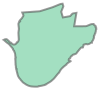

In [7]:
# read in the relevant files
df_nidmap = pd.read_csv(folder + '/OutputData/nid_map.csv')
nid_map = dict(zip(df_nidmap.nodeID, df_nidmap.node_name))
inv_nid_map = dict(zip(nid_map.values(), nid_map.keys()))  

bg_centroids = pd.read_pickle(folder + '/OutputData/bg_centroids.csv')
pgh_study_area = pd.read_pickle('pgh_study_area.csv')
pgh_study_area['geometry'][0]
coord_matrix = np.genfromtxt(folder + '/OutputData/coord_matrix')

In [8]:
coord_matrix.shape
df_nidmap.columns

(6597, 2)

Index(['nodeID', 'node_name'], dtype='object')

In [9]:
bbox_nhoods = pgh_study_area['geometry'].bounds.T.to_dict()[0]  # bounding box of neighborhood polygon layer
bbox_df = pgh_study_area['geometry'].bounds

In [10]:
# Parameters
walk_speed = 1.4 # m/s
#park_pphour = 2.50   # $; can be tuned       actually, going to the use the parking rate published with data
drive_speed = 5  # mph, speed as you go to park
num_park_hours = 4   # can be tuned
walk_speed = 1.3  # m/s
scoot_speed = 2.5  # m/s
scoot_ppmin = 0.39  # $/min
scoot_fix_price = 1  # $
bike_speed = 15 * 1000 / 3600  # m/s
bs_price = 20/300  # $/min
PT_price = 2.75  # $/ride
TNC_wait_time = 7 # min
TNC_fix_price = 2.55 + 3  # $  fixed cost + tax/fee (estimate tax+fee = 3, for simplicity)
TNC_op_ppmile = 1.75  # $/mile
TNC_op_ppmin =  1  #0.35  # $/min
pb_price = 0  # $
pv_ppmile = 0.20  # $/mile
zip_ppmin = 11/60   # $/min; still need to incorporate fixed monthly cost
zip_fixed_pmonth = 9
est_num_ziptrips = 4

# conversion factors
meters_in_mile = 1609
miles_in_km = 0.621371

# time-dependency: Consider a period of length 120 minutes (i.e. 7-9am), where each interval is 10 mintues long
interval_spacing = 10 # minutes
len_period = 120  # minutes
num_intervals = int(120/interval_spacing)+1

# beta parameters
b_price, b_TT, b_risk = 1, 21.59/60, 1    # b_risk should be tuned
# for median hourly wage estimate for PA: https://www.bls.gov/oes/current/oes_pa.htm
b_disc = b_TT  # b/c defined w.r.t. travel time
b_rel = b_TT  # b/c defined w.r.t. travel time

# First, for every edge in the G_bs network, add a "discomfort" cost associated with biking
# For simplicity, call it [some_scalar] * avg TT. So we will think of it in terms of TT minutes
# Move this scalar to the top of the code in the params 
discomf_weight = 1/10  # TO BE TUNED!
reliability_weight_active_mode = 1
reliability_weight_nonactive_mode = 1.5

active_modes = ['w','pb','bs','sc']
nonactive_mode = ['pv','pt','t','z']  
board_alight = ['board', 'alight']  # these are special case edges
reliability_weight_active_mode = 1
reliability_weight_nonactive_mode = 1.5

rel_weights = dict(zip(active_modes, [reliability_weight_active_mode]*len(active_modes)))
rel_weights.update(dict(zip(nonactive_mode, [reliability_weight_nonactive_mode]*len(nonactive_mode))))
rel_weights

active_modes = ['w','pb','bs','sc']
nonactive_mode = ['pv','pt','t','z']  # where to put board and alight? i think they are special cases

# define which nodes are fixed and which come from flexible networks 
all_fix_pre = ['bs','ps','k', 'zd', 'kz']  # prefix for fixed nodes
all_flex_pre = ['t', 'pb', 'pv', 'sc']  # prefix for flexible dropoff nodes

{'w': 1, 'pb': 1, 'bs': 1, 'sc': 1, 'pv': 1.5, 'pt': 1.5, 't': 1.5, 'z': 1.5}

In [11]:
# paraemters for scooter data generation
num_days_of_data = 30
num_obs_LB, num_obs_UB = 80, 100

In [12]:
modes_included = ['bs', 'z', 'sc', 't', 'pt'] # 'pb', 'pt', 'pv'] 
# this dict defines the node names corresponding to each mode type 
all_modes_nodes = {'bs':['bs'], 'pt':['ps','rt'], 't':['t'], 'sc':['sc'], 
                   'pv':['pv','k'], 'pb':['pb'], 'z':['zd','z','kz']}
# this dict defines which modes and nodes are included in the supernetwork
modes_nodes_included = {k:v for k,v in all_modes_nodes.items() if k in modes_included}

# prefixes for fixed nodes in the supernetwork
fix_pre = [n for nodes in modes_nodes_included.values() for n in nodes if n in all_fix_pre]
# prefixes for flex nodes in the supernetwork
flex_pre = [n for nodes in modes_nodes_included.values() for n in nodes if n in all_flex_pre]
print('fixed nodes included = ', fix_pre)
print('flex nodes included = ', flex_pre)

fixed nodes included =  ['bs', 'ps', 'zd', 'kz']
flex nodes included =  ['t', 'sc']


In [13]:
# parameters
#modes = ['bs', 'ps', 't', 'k', 'pb', 'sc', 'z'] # all modes
pmx = [('ps','ps'),('bs','ps'),('ps','bs'),('ps','t'),('t','ps'),('t','bs'),('bs','t'), # permitted mode change
       ('k','ps'),('k','t'),('k','bs'),('ps','pb'),('pb','ps'),('ps','sc'),('sc','ps'),('k','sc'),
       ('bs','sc'), ('sc','bs'), ('ps','zd'), ('bs','zd'), ('t','zd'), ('sc','zd'),
       ('kz','ps'),('kz','t'),('kz','bs'),('kz','sc')]     

In [14]:
W_od = 1 # mile

In [15]:
d = 1/10  # to be adj

## Functions

In [16]:
# returns the travel mode the corresponds to the node
def mode(node_name):
    mode_of_node = re.sub(r'[^a-zA-Z]', '', node_name)
    return mode_of_node
mode('bs1')

'bs'

In [17]:
def get_coord_matrix(G):
    coords_dict = nx.get_node_attributes(G, 'pos')
    nid_map = dict(zip(range(len(coords_dict.keys())), list(coords_dict.keys())))
    coord_matrix = np.array(list(coords_dict.values()))
    return (nid_map, coord_matrix)

In [18]:
# find the great circle distance between an input row (point) and a reference matrix (all other points)
# GCD: https://medium.com/@petehouston/calculate-distance-of-two-locations-on-earth-using-python-1501b1944d97#:~:text=The%20Great%20Circle%20distance%20formula,that%20the%20Earth%20is%20spherical.
# inputs: row (coords of single point), matrix_ref (coordinate matrix for all points)

# code source: https://github.com/gboeing/osmnx/blob/main/osmnx/distance.py
def calc_great_circle_dist(row, matrix_ref, earth_radius=6371009):
    y1 = np.deg2rad(row[1])  # y is latitude 
    y2 = np.deg2rad(matrix_ref[:,1])
    dy = y2 - y1

    x1 = np.deg2rad(row[0])
    x2 = np.deg2rad(matrix_ref[:,0])
    dx = x2 - x1

    h = np.sin(dy / 2) ** 2 + np.cos(y1) * np.cos(y2) * np.sin(dx / 2) ** 2
    h = np.minimum(1, h)  # protect against floating point errors
    arc = 2 * np.arcsin(np.sqrt(h))

    # return distance in units of earth_radius
    return arc * earth_radius

In [19]:
# this is only for edges that time-INdependent. we will update to include an attribute for each time interval
def update_td_edges(edges, num_intervals):
    updated_edges = []
    for e0, e1, attr_dict in edges:
        acopy = attr_dict.copy()
        TT_keys = ['interval'+str(i)+'_avg_TT_min' for i in range(num_intervals)]
        price_keys = ['interval'+str(i)+'_price' for i in range(num_intervals)]
        rel_keys = ['interval'+str(i)+'_reliability' for i in range(num_intervals)]
        TT_td_dict = dict(zip(TT_keys, num_intervals * [attr_dict['avg_TT_min']]))
        price_td_dict = dict(zip(price_keys, num_intervals * [attr_dict['price']]))
        rel_td_dict = dict(zip(rel_keys, num_intervals * [attr_dict['reliability']]))
        acopy.update(TT_td_dict)
        acopy.update(price_td_dict)
        acopy.update(rel_td_dict)
        updated_edges.append((e0, e1, acopy))
    return(updated_edges)

In [20]:
# returns walking catchment node for the node of interest
# inputs: nodeID of node interest, matrix of gc distances b/w all nodes, and max walking distance
# output: list of nodeIDs of all nodes within the wcz
def wcz(i, dist_matrix, W):
    catchment = np.where(dist_matrix[i] <= W)[0].tolist()
    if i in catchment:
        catchment.remove(i)  # remove self
    return catchment

In [21]:
# inputs: node of interest, matrix of gcd distances b/w all nodes, travel mode of interest, all nodes in the original graph (id+name)
# output: nodeID of the node in the component network of the travel mode of interest that is nearest to the input node of interest
def nn(i, dist_matrix, travel_mode, node_id_map):
    # subset the node_id_map for the nodes in the component network of the travel mode of interest
    nid_map_travel_mode = [key for key,val in node_id_map.items() if val.startswith(travel_mode)]   # this is a list of IDs
    # subset dist matrix for the nodes in the component network of the travel mode of interest
    dist_subset = dist_matrix[:, nid_map_travel_mode]
    # find the node in the component network of interest that is nearest to the input node of interest
    nn_dist = np.amin(dist_subset[i])
    nn_idx = np.argmin(dist_subset[i])
    # now map back to the original node ID
    original_nn_id = nid_map_travel_mode[nn_idx]
    original_nn_name = node_id_map[original_nn_id]
    return (original_nn_id, original_nn_name, nn_dist)

In [22]:
# inputs: graph, num of days of historical data, num of time intervals, num of scooter obs per time-interval day lower bound
# and upper bound, lower and upper bound of potential (x,y) coordinate of scooter, node id map, some cost parameters
# output: dict of dicts
def gen_data(G, n_days, n_intervals, n_obs_lb, n_obs_ub, xlb, xub, ylb, yub, 
             node_id_map_fixed, sc_fixcost, walk_speed, reliability_wts): #, avg_bike_segment_length):
    # generate some fake data

    # initialize the scooter cost dictionary: key is the fixed node, the value is dict of costs (different cost for the different time intervals)
    all_costs = dict([(n, {}) for n in node_id_map_fixed.values()])
    
    # For subsequent visualization purposes
    #fig, axs = plt.subplots(2, 5, sharex = True, sharey = True, figsize=(16,8))
    #plt.suptitle('Example: Scooter observations (red) for time interval 0 shown relative to fixed node bs1038 (blue)')
    # for subsequent plotting purposes 
    #node_coords = np.array([val for key,val in nx.get_node_attributes(G_u, 'pos').items() if key in list(node_id_map_fixed.values())])

    for i in range(n_intervals):  # each time interval 
        obs = {}  # obs is a dict, where the key is the day, the value is an array of coordinates representing different observations
        for j in range(n_days):  # each day
            n_obs = np.random.uniform(n_obs_lb,n_obs_ub)  # how many scooter observations for the day-time interval pair
            # generate some random data: data is a coordinate matrix
            # the scooter observations should fit within the bounding box of the neighborhood mask polygon layer
            data = [(round(np.random.uniform(xlb, xub),8), 
                     round(np.random.uniform(ylb, yub),8)) for k in range(int(n_obs))]  
            obs[j] = np.array(data)  

        # find edge cost
        node_cost_dict = {}
        for n in node_id_map_fixed.values():  # for each fixed node 
            all_min_dist = np.empty((1,n_days))  # initialize the min distance matrix, one entry per day
                       
            for d in range(n_days):  # how many days of historical scooter data we have 
                all_dist = calc_great_circle_dist(np.array(G.nodes[n]['pos']), obs[d])  # dist from the fixed node to all observed scooter locations 
                min_dist = np.min(all_dist)  # choose the scooter with min dist. assume a person always walks to nearest scooter
                all_min_dist[0,d] = min_dist # for the given day, the dist from the fixed node to the nearest scooter is min_dist
                
#                 if (i == 0 and n == 'bs1038'):   # testing
#                     print(all_dist)
                # **********************************
                # JUST FOR VISUALIZATION PURPOSES
#                 # for fixed node bs1038 and time interval 0, visualize the scooter location data for each day
#                 if (i == 0 and n == 'bs1037'):
#                     row = d // 5
#                     col = d if d <=4 else (d-5)
#                     for k in range(len(obs[d][:,0])):
#                         axs[row,col].plot([G.nodes[n]['pos'][0], obs[d][k,0]], [G.nodes[n]['pos'][1], obs[d][k,1]], 
#                                  c='grey', ls='--', marker = 'o', mfc='r', zorder=1)
#                     axs[row,col].scatter(x = G.nodes[n]['pos'][0], y = G.nodes[n]['pos'][1], c='b', s = 200, zorder=2)
#                     axs[row,col].set_title('Day ' + str(d))
#                     axs[row,col].text(-79.93, 40.412, 'closest scooter: ' + str(round(min_dist,3)) + ' miles', ha='center')
# #                 # **********************************
            
            mean_min_dist = np.mean(all_min_dist)  # mean distance from node n to any scooter in past "n_days" days
            p95 = np.percentile(all_min_dist, 95)  # 95th percentile distance from node n to any scooter in past "n_days" days
            
            node_cost_dict[n] = {'avg_TT_min': (mean_min_dist/walk_speed/60),
                                 'price': sc_fixcost,
                                 'reliability': p95/walk_speed/60,
                                 'risk_idx': 1,
                                 'mode_type':'w',
                                 'discomfort': discomf_weight * (mean_min_dist/walk_speed/60),
                                 'etype': 'transfer'}   # 

            
        for node, cost_dict in node_cost_dict.items():
            all_costs[node].update(cost_dict)

 
    return all_costs

In [23]:
# returns walking catchment node for the node of interest
# inputs: nodeID of node interest, matrix of gc distances b/w all nodes, and max walking distance
# output: list of nodeIDs of all nodes within the wcz
def wcz(i, dist_matrix, W):
    catchment = np.where(dist_matrix[i] <= W)[0].tolist()
    if i in catchment:
        catchment.remove(i)  # remove self
    return catchment

In [24]:
# this function builds OD connectors on the fly
# input: graphs, coordinates of the org and dst, the nodeID map, list of fixed nodes, list of flex modes, 
# gc dist between all nodes in the graph, max walk distance W, and walk speed parameter 
# output: graphs with OD connector edges added, along with their associated cost 

# note that there are some exceptions: 
# 1) org connects to flex PV;  2) org does not connect to fixed parking;  3) dst does not connect to flex PV
# 4) dst connects to fixed parking;  5) dst does not connect to fixed zip depot
def od_cnx(od_coord_matrix, node_id_map, fixed_node_list, fixed_mode_list, 
           flex_mode_list, gcd_matrix, W, walk_speed, TNC_wait_time, TNC_fixed_price,
           scooter_costs, discomfort_weight, reliability_weights):
    risk_idx = 1  # assume
    od_cnx_edges = {}
    inv_node_id_map = dict(zip(node_id_map.values(), node_id_map.keys())) 
        
    for i_name in ['org','dst']:
        catch = wcz(inv_node_id_map[i_name], gcd_matrix, W)  # find WCZ
        #print('-----')
        # build od connector edge for each FIXED node in the catchment zone 
        for j in catch:
            if j in fixed_node_list:
                j_name = node_id_map[j]  # map back to node name
                #print(j_name, mode(j_name))
                if ((i_name == 'org' and mode(j_name) == 'k') | (i_name == 'org' and mode(j_name) == 'kz') | (i_name == 'dst' and mode(j_name) == 'zd')):   
                    continue  # exceptions 2 and 5
                if i_name == 'org':
                    edge = (i_name, j_name)  # build org connector
                if i_name == 'dst':
                    edge = (j_name, i_name)  # build dst connector     
                
                walk_time = gcd_matrix[inv_node_id_map[i_name], j] / walk_speed / 60  # walking traversal time [min] of edge
                wait_time = 0 
                # note that wait time is not included. this is because we're dealing with fixed modes. only TNC has wait time
                # wait time for PT is embedded in alighting edges
                fixed_price = 0  # for all fixed modes
                attr_dict = {'avg_TT_min': walk_time + wait_time,
                             'price': fixed_price,
                             'reliability': (walk_time + wait_time) * reliability_weights['w'],
                             'risk_idx': 1,  # for now, just assume all transfers associated with risk = 1
                             'discomfort': discomfort_weight * walk_time,
                             'type': 'od_cnx',
                             'mode_type': 'w'}                
                od_cnx_edges[edge] = attr_dict
                
                #approx_num_walk_segments = gcd_matrix[inv_node_id_map[i_name], j] / avg_bike_segment_length
                #risk_cost = b_risk * risk_idx * approx_num_walk_segments
                #print(walk_cost)

                # add an edge attribute for num_intervals different costs to match the num_intervals time-dependent traversal edge costs
                # but the transfer edge cost is constant for all times 
#                 attr_dict = dict(zip(cost_keys, [walk_cost + risk_cost]*num_intervals))  # holds costs attributes
#                 attr_dict['type'] = 'cnx'    # store edge type
#                 od_cnx_edges[edge] = attr_dict
                
        # some fixed modes do not have a node within the wcz. for these modes, we will instead connect the 
        # org or dst to the nearest neighbor node of for these specific fixed modes. consider this like 
        # relaxing the wcz constraint
        catch_node_names = [node_id_map[c] for c in catch]
        catch_fixed_modes = [re.sub(r'[^a-zA-Z]', '', cname) for cname in catch_node_names]
        
        # which fixed mode does not have a node in the wcz?
        rem_fixed_modes = set(fixed_mode_list) - set(catch_fixed_modes)
        for rm in rem_fixed_modes:
            if ((i_name == 'org' and rm == 'k') | (i_name == 'org' and rm == 'kz') | (i_name == 'dst' and rm == 'zd')):   # exceptions 2/5
                continue
            # nn calc
            nnID, nnName, nnDist = nn(inv_nid_map[i_name], gcd_matrix, rm, node_id_map) 
            r_name = nnName
            cnx_edge_length = nnDist
            walk_time = cnx_edge_length / walk_speed / 60  # [min]
            wait_time = 0
            fixed_price = 0
            
            attr_dict = {'avg_TT_min': walk_time + wait_time,
                         'price': fixed_price,
                         'reliability': (walk_time + wait_time) * reliability_weights['w'],
                         'risk_idx': 1,  # for now, just assume all transfers associated with risk = 1
                         'discomfort': discomfort_weight * walk_time,
                         'type': 'od_cnx',
                         'mode_type': 'w'}                

            if i_name == 'org':
                edge = (i_name, r_name)  # build org connector
            if i_name == 'dst':
                edge = (r_name, i_name)  # build dst connector
            
            od_cnx_edges[edge] = attr_dict  

        # build od connector edge for the nearest flexible node (relax constraints that needs to be in wcz)
        # also includes an org connector from org to nearest PV node, but does NOT include a dst connector from dst to nearest PV node
        # PV = personal vehicle 
        for m in flex_mode_list:
            if i_name == 'dst' and m == 'pv':  # exception 3
                continue
            nnID, nnName, nnDist = nn(inv_nid_map[i_name], gcd_matrix, m, node_id_map) 
            k_name = nnName
            #print(k_name)
            #if nnID in catch:   *we have decided to relax this constraint*
            
            # do this separately for scooters/TNCs and other flex modes. but have not yet generated TNC data to account for variable pickup wait times
            if (i_name == 'org' and m == 'sc'):
                edge = (i_name, k_name)
                #print(edge)
                sc_cost_dict = scooter_costs[i_name]
                sc_cost_dict['type'] = 'cnx'    # store edge type
                od_cnx_edges[edge] = sc_cost_dict

            else:   
                cnx_edge_length = nnDist
                walk_time = cnx_edge_length / walk_speed / 60  # [min]
                wait_time = TNC_wait_time if (m == 't') & (i_name == 'org') else 0
                fixed_price = TNC_fix_price if (m == 't') & (i_name == 'org') else 0
                # to do: add zip fixed price, maybe 9/4
                
                attr_dict = {'avg_TT_min': walk_time + wait_time,
                             'price': fixed_price,
                             'reliability': (walk_time + wait_time) * reliability_weights['w'],
                             'risk_idx': 1,  # for now, just assume all transfers associated with risk = 1
                             'discomfort': discomfort_weight * walk_time,
                             'type': 'od_cnx',
                             'mode_type': 'w'}                
                
                if i_name == 'org':
                    edge = (i_name, k_name)  # build org connector
                if i_name == 'dst':
                    edge = (k_name, i_name)  # build dst connector
                
                od_cnx_edges[edge] = attr_dict  
    return od_cnx_edges

In [25]:
# Make the graph, nid_map, and coordinate matrix
G_u = nx.from_pandas_edgelist(df_linkcost, edge_attr=True, create_using=nx.DiGraph())
#nid_map, coord_matrix = get_coord_matrix(G_u)
# coord matrix is np array where row i contains the lat/long pair of node i
# node ID map is of form {id_number: node_name}. also make inverse node ID map of form {node_name: id_number}



In [26]:
def two_pts_gcd(row1, row2, earth_radius=6371009):
    y1 = np.deg2rad(row1[1])  # y is latitude 
    y2 = np.deg2rad(row2[1])
    dy = y2 - y1

    x1 = np.deg2rad(row1[0])
    x2 = np.deg2rad(row2[0])
    dx = x2 - x1

    h = np.sin(dy / 2) ** 2 + np.cos(y1) * np.cos(y2) * np.sin(dx / 2) ** 2
    h = np.minimum(1, h)  # protect against floating point errors
    arc = 2 * np.arcsin(np.sqrt(h))

    # return distance in units of earth_radius
    return arc * earth_radius

In [28]:
bg_centroids.reset_index(inplace=True)
test_centroid_pairs = []
all_centroid_pairs = list(itertools.permutations(list(bg_centroids.index), 2))

for pair in all_centroid_pairs:
    r1 = np.array(bg_centroids.iloc[pair[0]][['x','y']])
    r2 = np.array(bg_centroids.iloc[pair[1]][['x','y']])
    dist = two_pts_gcd(r1, r2)
    if dist / meters_in_mile > 3.2:
#         print(pair)
#         print(dist / meters_in_mile)
        test_centroid_pairs.append(pair)

The supernetwork is already built. It includes transfer edges. Link costs have already been defined. This is all in the df_linkcost dataframe. What is left to do is define the OD pair, build od cnx edges, and run shortest path

**Step 1**: Define the OD pair using the bg_centroids df

In [29]:
# get all possible OD pairs
indices = list(range(len(bg_centroids)))
idx_pairs = list(itertools.permutations(indices, 2))
# For now, just test with the first 15 pairs
od_pairs = idx_pairs[::200]
test = [od_pairs[3]]
test
len(od_pairs)
# some testing
for i in range(0,len(od_pairs),10):
    o,d = od_pairs[i]
    print(o,d)

[(11, 29)]

14

0 1
38 24


**Step 2**: Build connection edges

In [ ]:
    # cell copied from above. can be deleted later. used for now for testing purposes just to make sure nid_map is reset
    nid_map = dict(zip(range(len(list(G_u.nodes))), G_u.nodes))
    inv_nid_map = dict(zip(nid_map.values(), nid_map.keys()))  
    
    # gcd distance matrix: gcd_dist[i,j] is the great circle distance from node i to node j
    gcd_dist = np.empty([len(nid_map), len(nid_map)])  # great circle dist in meters 
    for i in range(gcd_dist.shape[0]):
        dist_to_all_nodes = calc_great_circle_dist(coord_matrix[i], coord_matrix)  # calc distance from node i to all other nodes
        gcd_dist[i] = dist_to_all_nodes  # calc_great_circle_dist is a function defined above 

In [42]:
import math

In [30]:
# only keep cost columns
cost_cols = ['interval'+str(i)+'_COST' for i in range(num_intervals)]
cols_keep = ['source','target','mode_type'] + cost_cols

In [45]:
# Add each OD pair and do calcs on the fly
risk_idx = 1  # approx walking risk index per segment

for i in range(math.floor(len(test_centroid_pairs)/2)):  #range(0,len(od_pairs),10):
    o,d = test_centroid_pairs[i]

    # cell copied from above. can be deleted later. used for now for testing purposes just to make sure nid_map is reset
    nid_map = dict(zip(range(len(list(G_u.nodes))), G_u.nodes))
    inv_nid_map = dict(zip(nid_map.values(), nid_map.keys()))  
    
    # gcd distance matrix: gcd_dist[i,j] is the great circle distance from node i to node j
    gcd_dist = np.empty([len(nid_map), len(nid_map)])  # great circle dist in meters 
    for i in range(gcd_dist.shape[0]):
        dist_to_all_nodes = calc_great_circle_dist(coord_matrix[i], coord_matrix)  # calc distance from node i to all other nodes
        gcd_dist[i] = dist_to_all_nodes  # calc_great_circle_dist is a function defined above 

    G_u_od = G_u.copy()  # helpful to do everything on a graph copy 
    #G_u_od_adj = G_u_adj.copy()
    o_coord = (bg_centroids.iloc[o]['geometry'].x, bg_centroids.iloc[o]['geometry'].y)
    d_coord = (bg_centroids.iloc[d]['geometry'].x, bg_centroids.iloc[d]['geometry'].y)
    print(o_coord,d_coord)

    # add the org and dst nodes to the graph along with their positions 
    G_u_od.add_nodes_from([('org', {'pos': o_coord}),   # 'org'+str(i)
                           ('dst', {'pos': d_coord})])

    # build od coord matrix
    od_coords = np.array([list(o_coord),list(d_coord)])

    # create new great circle distance matrix, called gcd_od, where gcd_od[0,j] is the distance from the org
    # to the node with node_id = j and gcd_od[1,j] is the distance from the dst to the node with node_id = j

    # 2 rows because 1 origin and 1 destination 
    nrow, ncol = 2, len(nid_map) + 2  # add 2 to len(nid_map) to account for addition of org node and dst node

    gcd_od = np.empty([nrow, ncol])  
    for j in range(nrow):  # first the org, then the dest
        dist_to_map_nodes = calc_great_circle_dist(od_coords[j], coord_matrix) # dist from OD to modal graph nodes
        dist_to_od = calc_great_circle_dist(od_coords[j], od_coords) # dist from O to O and O to D, then D to O and D to D
        gcd_od[j] = np.hstack((dist_to_map_nodes, dist_to_od)) # horizontally concatenate 

    # now add gcd_dist_od to the original gcd_dist matrix
    # result is gcd_dist_all, which contains the gcd dist b/w all pairs of nodes in the graph, including org and dst
    gcd_dist_all = np.vstack((gcd_dist, gcd_od[:,:len(nid_map)]))
    gcd_dist_all = np.hstack((gcd_dist_all, np.transpose(gcd_od)))

    # add the org and dest to the nid_map and recreate the inverse map
    # also get nid map just for org and dst. useful b/c ...
    nid_map_od = {}

    nid_map[max(nid_map.keys())+1] = 'org'
    nid_map_od[max(nid_map.keys())+1] = 'org'
    nid_map[max(nid_map.keys())+1] = 'dst'
    nid_map_od[max(nid_map.keys())+1] = 'dst'
    inv_nid_map = dict(zip(nid_map.values(), nid_map.keys()))
    
    # separate nid map into fixed and flex
    nid_map_fixed = {key:val for key,val in nid_map.items() if mode(val) in fix_pre}  # nid_map for fixed network nodes
    nid_map_flex = {key:val for key,val in nid_map.items() if mode(val) in flex_pre}  # nid_map for flex network nodes

    # cost of transferring to scooter from ORG and to DST from scooter 
    # graph is expectedly blank since it pertains to a fixed bikeshare node
    sc_costs_od = gen_data(G_u_od, num_days_of_data, num_intervals, num_obs_LB, num_obs_UB, 
                           bbox_nhoods['minx'], bbox_nhoods['maxx'], bbox_nhoods['miny'], bbox_nhoods['maxy'],
                           nid_map_od, scoot_fix_price, walk_speed, rel_weights)

    # Build OD connectors
    W_od = 1  # [miles] consider this value more carefully
    # consider it such that the max walking constraint has been largely relaxed


    od_cnx_edges = od_cnx(od_coords, nid_map, list(nid_map_fixed.keys()), fix_pre, flex_pre, gcd_dist_all, 
                          W_od * meters_in_mile, walk_speed, TNC_wait_time, TNC_fix_price, sc_costs_od, 
                          discomf_weight, rel_weights)    

    
    # add org-dst edge directly, to account for an OD pair that is walkable 
    OD_dist = gcd_dist_all[inv_nid_map['org'], inv_nid_map['dst']]
    print(OD_dist)
    walk_time = OD_dist / walk_speed / 60  # walk time in minutes
    attr_dict = {'avg_TT_min': walk_time,
                 'price': 0,
                 'reliability': (walk_time) * rel_weights['w'],
                 'risk_idx': 1,  # for now, just assume all transfers associated with risk = 1
                 'discomfort': discomf_weight * walk_time,
                 'type': 'od_cnx',
                 'mode_type': 'w'} 
    
    od_cnx_edges[('org', 'dst')] = attr_dict
    od_cnx_edges[('dst', 'org')] = attr_dict
    
    # now add costs for each time interval
    od_cnx_edges_newform = list(zip(list(zip(*od_cnx_edges.keys()))[0], list(zip(*od_cnx_edges.keys()))[1], od_cnx_edges.values()))
    new_od_cnx_edges = update_td_edges(od_cnx_edges_newform, num_intervals)
    

    # make networkx graph of od cnx edges b/c it will be easy to merge with graph of traversal/transfer edges
    G_odc = nx.DiGraph()
    G_odc.add_edges_from(new_od_cnx_edges)
    df_Godc = nx.to_pandas_edgelist(G_odc)

    for i in range(num_intervals):
        df_Godc.loc[:,'interval'+str(i)+'_COST'] = (b_TT * df_Godc.loc[:,'interval'+str(i)+'_avg_TT_min'] +
                                                    b_rel * df_Godc.loc[:,'interval'+str(i)+'_reliability'] +
                                                    b_price * df_Godc.loc[:,'interval'+str(i)+'_price'] +
                                                    b_disc * df_Godc.loc[:,'discomfort'] +
                                                    b_risk * df_Godc.loc[:,'risk_idx']) 
    df_Godc = df_Godc[cols_keep]

    # one final network topology graph
    df_graph_final_od = pd.concat([df_linkcost, df_Godc], ignore_index=True)

    # convert back to networkx graph and run shortest path
    # this is a process we will do in MAC-POSTS. for now we are just doing it here as prelim testing to find "good" ODs
    G_final = nx.from_pandas_edgelist(df_graph_final_od, 'source', 'target', edge_attr=True, create_using = nx.DiGraph())
    
#     path = nx.shortest_path(G_final, 'org', 'dst', 'interval0_COST')
#     print(path)
    print('-----')
    path = nx.shortest_path(G_final, 'org', 'dst', 'interval6_COST')
    print(path)

    
#     G_u_od.add_edges_from(list(od_cnx_edges.keys()))  # real graph
#     nx.set_edge_attributes(G_u_od, od_cnx_edges) # attributes

#     # add org-dst edge directly, to account for an OD pair that is walkable 
    
#     OD_dist = gcd_dist_all[inv_nid_map['org'], inv_nid_map['dst']]
    
# #     G_u_od.add_edges_from([('org','dst'), ('dst','org')])
# #     od_walk_cost = b_TT * (OD_dist / walk_speed / 60)  # [min]
# #     risk_cost = b_risk * risk_idx * (OD_dist / avg_bike_seg_length)
# #     nx.set_edge_attributes(G_u_od, {('org','dst'): dict(zip(cost_keys, [od_walk_cost + risk_cost]*num_intervals))}) 
# #     nx.set_edge_attributes(G_u_od, {('dst','org'): dict(zip(cost_keys, [od_walk_cost + risk_cost]*num_intervals))}) # attributes
    
# #     shortest_path_edges, shortest_path_cost = dijkstra(G_u_od, 'org', 'dst', 'interval0_COST')
# #     print(shortest_path_edges)
# #     print(shortest_path_cost)
#     sp = nx.shortest_path(G_u_od, 'org', 'dst', 'interval0_COST')
#     print(sp)
#     print('********************')
    

(-79.93983859983733, 40.402259197370014) (-79.91171217866723, 40.446232085282055)
5438.420419251214
-----
['org', 'ps18985', 'ps8374', 'dst']
(-79.93983859983733, 40.402259197370014) (-79.92360137918944, 40.44837142411909)
5308.470325951717
-----
['org', 'ps19902', 'ps20486', 'dst']
(-79.93983859983733, 40.402259197370014) (-79.91437700425736, 40.44437481956643)
5155.228175831588
-----
['org', 'ps18985', 'ps8472', 'dst']
(-79.93983859983733, 40.402259197370014) (-79.91178747153035, 40.44678200706096)
5490.6996090406765
-----
['org', 'ps18985', 'ps8374', 'dst']
(-79.93983859983733, 40.402259197370014) (-79.9209880904642, 40.44714279303008)
5239.711240778638
-----
['org', 'ps18985', 'ps8472', 'dst']
(-79.93983859983733, 40.402259197370014) (-79.93173178389021, 40.44917855660593)
5262.137553814859
-----
['org', 'ps12079', 'ps12250', 'dst']
(-79.93983859983733, 40.402259197370014) (-79.9260764776549, 40.45109322524138)
5553.650269481186
-----
['org', 'ps7324', 'ps7089', 'dst']
(-79.9398385

In [48]:
inv_nid_map['org']
inv_nid_map['dst']

6597

6598

**Step 3**: Prepare files for compatibility with MAC-POSTS

In [49]:
# add link ID
df_graph_final_od['link_ID'] = df_graph_final_od.index
df_graph_final_od.head(3)

,source,target,mode_type,interval0_COST,interval1_COST,interval2_COST,interval3_COST,interval4_COST,interval5_COST,interval6_COST,interval7_COST,interval8_COST,interval9_COST,interval10_COST,interval11_COST,interval12_COST,linkID,link_ID
0,bs49201,bs1085,bs,19.868543,19.868543,19.868543,19.868543,19.868543,19.868543,19.868543,19.868543,19.868543,19.868543,19.868543,19.868543,19.868543,0.0,0
1,bs49201,bs1037,bs,74.010280,74.010280,74.010280,74.010280,74.010280,74.010280,74.010280,74.010280,74.010280,74.010280,74.010280,74.010280,74.010280,1.0,1
2,bs49201,bs1070,bs,64.529858,64.529858,64.529858,64.529858,64.529858,64.529858,64.529858,64.529858,64.529858,64.529858,64.529858,64.529858,64.529858,2.0,2


In [50]:
len(list(inv_nid_map))
len(list(G_final.nodes))
inv_nid_map['bs49201']

6599

6599

0

In [51]:
# 1. create the graph topology 
df_graph_final_od['source_nodeID'] = df_graph_final_od.apply(lambda row: inv_nid_map[row['source']], axis=1)
df_graph_final_od['target_nodeID'] = df_graph_final_od.apply(lambda row: inv_nid_map[row['target']], axis=1)
graph = df_graph_final_od[['link_ID', 'source_nodeID', 'target_nodeID']]
graph.columns = ['EdgeId', 'FromNodeId', 'ToNodeId']

filename = 'graph'
np.savetxt(filename, graph, fmt='%d', delimiter=' ')
f = open(filename, 'r')
log = f.readlines()
f.close()
log.insert(0, 'EdgeId FromNodeId ToNodeId\n')
f = open(filename, 'w')
f.writelines(log)
f.close()

In [52]:
# 2. create link cost file 
td_link_cost = df_graph_final_od[['link_ID'] + cost_cols]
filename = 'td_link_cost'
np.savetxt(filename, td_link_cost, fmt='%d ' + (num_intervals-1)*'%f ' + '%f')
f = open(filename, 'r')
log = f.readlines()
f.close()
log.insert(0, 'link_ID td_cost\n')
f = open(filename, 'w')
f.writelines(log)
f.close()

In [53]:
td_link_cost.shape

(64175, 14)

In [54]:
edges = tuple(zip(df_graph_final_od['source'], df_graph_final_od['target']))
link_ID_map = dict(zip(edges, df_graph_final_od['link_ID']))

In [103]:
# Create node cost df to prevent org-ps-ps or ps-ps-dst transfers
node_costs = []
for n in list(G_final.nodes):
    edges_in = list(G_final.in_edges(n))
    edges_out = list(G_final.out_edges(n))
    for ei in edges_in:
        # return the in_link ID
        linkID_in = link_ID_map[ei]
        for eo in edges_out:        
             # return the out_link ID
            linkID_out = link_ID_map[eo]   
            #print(ei, eo)
            if ((mode(ei[0]), mode(ei[1])) in pmx) & ((mode(eo[0]), mode(eo[1])) in pmx):
                node_costs.append([inv_nid_map[n], link_ID_map[ei], link_ID_map[eo]])
            if (ei[0].startswith('org')) & ((mode(eo[0]), mode(eo[1])) in pmx):  # prevent od_cnx - transfer
                node_costs.append([inv_nid_map[n], link_ID_map[ei], link_ID_map[eo]])
            if ((mode(ei[0]), mode(ei[1])) in pmx) & (eo[1].startswith('dst')):  # prevent transfer - od_cnx
                node_costs.append([inv_nid_map[n], link_ID_map[ei], link_ID_map[eo]])   


            #if n.startswith('ps'):  # this only applies to physical stops to prevent ps-ps-ps
#             if (ei[0].startswith('org')) & (eo[1].startswith('ps')):  # prevent org-ps-ps
#                 node_costs.append([inv_nid_map[n], link_ID_map[ei], link_ID_map[eo]])
#             if (ei[0].startswith('ps')) & (eo[1].startswith('dst')):  # prevent ps-ps-dst
#                 node_costs.append([inv_nid_map[n], link_ID_map[ei], link_ID_map[eo]])

In [104]:
df_nodecost = pd.DataFrame(node_costs, columns = ['node_ID', 'in_link_ID', 'out_link_ID'])
for i in range(num_intervals):
    df_nodecost['interval'+str(i)+'_COST'] = 100000 # some arbitarily large number to prevent unwanted transfers

In [101]:
df_nodecost.head(10)

,node_ID,in_link_ID,out_link_ID,interval0_COST,interval1_COST,interval2_COST,interval3_COST,interval4_COST,interval5_COST,interval6_COST,interval7_COST,interval8_COST,interval9_COST,interval10_COST,interval11_COST,interval12_COST
0,0,8732,7,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000
1,0,8732,8,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000
2,0,8732,9,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000
3,0,8732,10,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000
4,0,8732,11,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000
5,0,8732,12,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000
6,0,8732,13,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000
7,0,8732,14,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000
8,0,8732,15,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000
9,0,8732,16,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000


In [ ]:
os.getcwd()

In [105]:
# 3) create node cost file
td_node_cost = df_nodecost.copy()
filename = 'td_node_cost'
np.savetxt(filename, td_node_cost, fmt='%d %d %d ' + (num_intervals-1)*'%f ' + '%f')
f = open(filename, 'r')
log = f.readlines()
f.close()
log.insert(0, 'node_ID in_link_ID out_link_ID td_cost\n')
f = open(filename, 'w')
f.writelines(log)
f.close()

In [106]:
df_graph_final_od.shape[0]
df_nodecost.shape[0]

64175

2770123

In [107]:
# Edit the conf file
def edit_config(folder, graph_name, len_link_file, len_node_file):
    with open(folder + '/config.conf', 'w') as f:
        f.write('[Network] \n')
        f.write('network_name = ' + graph_name + '\n')
        f.write('num_of_link = ' + str(len_link_file) + '\n')
        f.write('num_of_node = ' + str(len_node_file) + '\n')
        #f.write('num_of_link = ' + str(df_linkcost.shape[0]) + '\n')
        #f.write('num_of_node = ' + str(df_nodecost.shape[0]))

In [108]:
# 4) edit the config file
folder = os.getcwd()
edit_config(folder, 'graph', df_graph_final_od.shape[0], df_nodecost.shape[0])

In [109]:
td_node_cost.shape

(2770123, 16)

In [110]:
# 5) run shortest path
max_interval = num_intervals
num_rows_link_file = df_graph_final_od.shape[0]
num_rows_node_file = df_nodecost.shape[0]
link_cost_file_name = "td_link_cost"
node_cost_file_name = "td_node_cost"

dest_node_ID = inv_nid_map['dst']
origin_node_ID = inv_nid_map['org']

In [111]:
# %%
tdsp_api = MNMAPI.tdsp_api()
tdsp_api.initialize(folder, max_interval, num_rows_link_file, num_rows_node_file, link_cost_file_name, 
                    node_cost_file_name)


0

In [112]:
# %%
tdsp_api.build_tdsp_tree(dest_node_ID)

# %%
timestamp = 8
tdsp = tdsp_api.extract_tdsp(origin_node_ID, timestamp)
# tdsp : number of nodes * 3
# first col: node sequence
# second col: link sequence with last element being -1
# third col: first element being the travel time
print(tdsp)

0

[[ 6.59700000e+03  6.39420000e+04  2.29680979e+01]
 [ 3.02300000e+03  3.91440000e+04 -1.00000000e+00]
 [ 5.67700000e+03  3.91880000e+04 -1.00000000e+00]
 [ 5.52100000e+03  3.47770000e+04 -1.00000000e+00]
 [ 3.01700000e+03  6.40240000e+04 -1.00000000e+00]
 [ 6.59800000e+03 -1.00000000e+00 -1.00000000e+00]]


In [113]:
for n in tdsp[:,0]:
    print(nid_map[int(n)])

org
ps7088
rt7088_61A_1_59
rt7089_61A_1_60
ps7089
dst


In [77]:
all_modes_nodes = {'bs':['bs'], 'pt':['ps','rt'], 't':['t'], 'sc':['sc'], 
                   'pv':['pv','k'], 'pb':['pb'], 'z':['zd','z','kz']}
all_nodes = [item for sublist in list(all_modes_nodes.values()) for item in sublist]
all_nodes.remove('ps')
all_nodes
pmx

['bs', 'rt', 't', 'sc', 'pv', 'k', 'pb', 'zd', 'z', 'kz']

[('ps', 'ps'),
 ('bs', 'ps'),
 ('ps', 'bs'),
 ('ps', 't'),
 ('t', 'ps'),
 ('t', 'bs'),
 ('bs', 't'),
 ('k', 'ps'),
 ('k', 't'),
 ('k', 'bs'),
 ('ps', 'pb'),
 ('pb', 'ps'),
 ('ps', 'sc'),
 ('sc', 'ps'),
 ('k', 'sc'),
 ('bs', 'sc'),
 ('sc', 'bs'),
 ('ps', 'zd'),
 ('bs', 'zd'),
 ('t', 'zd'),
 ('sc', 'zd'),
 ('kz', 'ps'),
 ('kz', 't'),
 ('kz', 'bs'),
 ('kz', 'sc')]

In [ ]:
# Create node cost df to prevent org-ps-ps or ps-ps-dst transfers
node_costs = []
for n in list(G_final.nodes)[:200]:
    edges_in = list(G_final.in_edges(n))
    edges_out = list(G_final.out_edges(n))
    for ei in edges_in:
        # return the in_link ID
        linkID_in = link_ID_map[ei]
        for eo in edges_out:        
             # return the out_link ID
            linkID_out = link_ID_map[eo]   
            #print(ei, eo)
            if ((mode(ei[0]), mode(ei[1])) in pmx) & ((mode(eo[0]), mode(eo[1])) in pmx):
                node_costs.append([inv_nid_map[n], link_ID_map[ei], link_ID_map[eo]])
    
            if (ei[0].startswith('org')) & ((mode(eo[0]), mode(eo[1])) in pmx):  # prevent od_cnx - transfer
                node_costs.append([inv_nid_map[n], link_ID_map[ei], link_ID_map[eo]])
            if ((mode(ei[0]), mode(ei[1])) in pmx) & (eo[1].startswith('dst')):  # prevent transfer - od_cnx
                node_costs.append([inv_nid_map[n], link_ID_map[ei], link_ID_map[eo]])    


            #if n.startswith('ps'):  # this only applies to physical stops to prevent ps-ps-ps
#             if (ei[0].startswith('org')) & (eo[1].startswith('ps')):  # prevent org-ps-ps
#                 node_costs.append([inv_nid_map[n], link_ID_map[ei], link_ID_map[eo]])
#             if (ei[0].startswith('ps')) & (eo[1].startswith('dst')):  # prevent ps-ps-dst
#                 node_costs.append([inv_nid_map[n], link_ID_map[ei], link_ID_map[eo]])